In [ ]:
#Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#cargamos nuestro Token de Kaggle
from google.colab import files
files.upload()

#Iniciamos la instalación de la API para cargar el dataset
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d carrie1/ecommerce-data
!unzip ecommerce-data.zip #otra opcion es !unzip -o , la cual sobrescribe automáticamente.

Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown
ecommerce-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ecommerce-data.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## 1. Exploración inicial y tipos de datos

In [ ]:
#Mostamos los primeros 10 datos del dataset (el dataset debe ser )
df = pd.read_csv('data.csv',  encoding='latin-1')
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [ ]:
#Atributos de las columnas
print("Datos originales:\n", df.columns.tolist())

#Verificar tipos de datos
print("\nTipos de datos originales:\n", df.dtypes)

#Identificar valores nulos
null_counts = df.isnull().sum()
print("\nCantidad de nulos por columna:\n", null_counts)

Datos originales:
 ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Tipos de datos originales:
 InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Cantidad de nulos por columna:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


## 1.1 Preprocesamiento básico de datos
Sabiendo la cantidad de nulos y dtype de los datos es que pasaremos a limpiar nuestro dataset

In [88]:
import pandas as pd

def clean_and_transform_data(df):
    """
    Realiza limpieza y transformación completa del dataset de e-commerce.

    Parámetros:
    df -- DataFrame original a procesar

    Retorna:
    DataFrame limpio y con tipos de datos optimizados
    """

    ## 1. Normalización de texto y detección de valores problemáticos
    # Convertir descripciones a minúsculas
    df['lowercase_descriptions'] = df['Description'].str.lower()

    # Identificar y contar valores problemáticos
    problematic_values = {
        'nan_strings': df['lowercase_descriptions'].str.contains('nan', na=False).sum(),
        'empty_strings': df['lowercase_descriptions'].eq('').sum()
    }

    print(f"\nValores problemáticos detectados:")
    print(f"- Textos 'nan': {problematic_values['nan_strings']}")
    print(f"- Strings vacíos: {problematic_values['empty_strings']}")

    ## 2. Limpieza de datos
    # Reemplazar valores problemáticos y limpiar
    df['clean_descriptions'] = (
        df['lowercase_descriptions']
        .replace(['nan', ''], pd.NA)
        .fillna("NO_DESCRIPTION")
    )

    # Filtrar registros válidos (con CustomerID y descripción)
    df = df.dropna(subset=['CustomerID']).copy()

    ## 3. Optimización de tipos de datos
    type_conversions = {
        'CustomerID': 'Int64',
        'Description': 'string',
        'StockCode': 'string',
        'Country': 'category',
        'clean_descriptions': 'string'
    }

    for col, dtype in type_conversions.items():
        df[col] = df[col].astype(dtype)

    # Conversión especial para fecha
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

    ## 4. Validación final
    print("\nResumen post-limpieza:")
    print(f"Registros totales: {len(df)}")
    print(f"Descripciones faltantes: {df['clean_descriptions'].eq('NO_DESCRIPTION').sum()}")

     # Eliminar columna temporal antes de retornar
    df.drop(columns=['lowercase_descriptions'], inplace=True)

    print("\nTipos de datos finales:")
    print(df.dtypes)

    return df

# Ejecutar la limpieza
df_clean = clean_and_transform_data(df)


Valores problemáticos detectados:
- Textos 'nan': 606
- Strings vacíos: 0

Resumen post-limpieza:
Registros totales: 406829
Descripciones faltantes: 0

Tipos de datos finales:
InvoiceNo                     object
StockCode             string[python]
Description           string[python]
Quantity                       int64
InvoiceDate           datetime64[ns]
UnitPrice                    float64
CustomerID                     Int64
Country                     category
TotalAmount                  float64
clean_descriptions    string[python]
dtype: object


## 1.2 Identificación y clasificación de variables

In [89]:
# VARIABLES NUMÉRICAS ---------------------
# Continuas
numericas_continuas = ['UnitPrice']  # Precios unitarios
# Discretas
numericas_discretas = ['Quantity']   # Cantidades de productos

# VARIABLES CATEGÓRICAS ---------------------
# Nominales
categoricas_nominales = [
    'InvoiceNo',            # ID de factura
    'StockCode',            # Código de producto
    'clean_descriptions',   # Descripción del producto
    'Country',              # País
    'CustomerID'            # ID de cliente
]
# Ordinales
categoricas_ordinales = []


#variables temporales
temporales = ['InvoiceDate']  # Fecha y hora de la transacción


print("\nClasificación actualizada de variables:")
print(f"Numéricas continuas: {numericas_continuas}")
print(f"Numéricas discretas: {numericas_discretas}")
print(f"Categóricas nominales: {categoricas_nominales}")
print(f"Temporales: {temporales}")


Clasificación actualizada de variables:
Numéricas continuas: ['UnitPrice']
Numéricas discretas: ['Quantity']
Categóricas nominales: ['InvoiceNo', 'StockCode', 'clean_descriptions', 'Country', 'CustomerID']
Temporales: ['InvoiceDate']


# 2. Análisis estadístico descriptivo
Para un mejor manejo de los datos, calcularemos un monto total por transacción y generaremos un nuevo dataframe (customer_invoices) que nos permitirá analizar el gasto acumulado y la frecuencia de compra de cada cliente. Este proceso nos proporcionará una visión consolidada del comportamiento de compra, facilitando la identificación de patrones y oportunidades comerciales.

In [90]:
#Creamos un monto total para manejar las compras
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

#Df agrupa número de boleta e ID de cliente para saber el total de su compra ----------------------------
customer_invoices = df.groupby(['InvoiceNo', 'CustomerID']).agg({
    'InvoiceDate': 'first',
    'Country': 'first',
    'TotalAmount': 'sum',    # Suma del monto total por factura
    'Quantity': 'sum',       # Suma de cantidades compradas
    'StockCode': 'nunique',  # Número de productos únicos en la factura
}).reset_index()

# Ver resultados
print(customer_invoices.head(10))

  InvoiceNo  CustomerID         InvoiceDate         Country  TotalAmount  \
0    536365       17850 2010-12-01 08:26:00  United Kingdom       139.12   
1    536366       17850 2010-12-01 08:28:00  United Kingdom        22.20   
2    536367       13047 2010-12-01 08:34:00  United Kingdom       278.73   
3    536368       13047 2010-12-01 08:34:00  United Kingdom        70.05   
4    536369       13047 2010-12-01 08:35:00  United Kingdom        17.85   
5    536370       12583 2010-12-01 08:45:00          France       855.86   
6    536371       13748 2010-12-01 09:00:00  United Kingdom       204.00   
7    536372       17850 2010-12-01 09:01:00  United Kingdom        22.20   
8    536373       17850 2010-12-01 09:02:00  United Kingdom       259.86   
9    536374       15100 2010-12-01 09:09:00  United Kingdom       350.40   

   Quantity  StockCode  
0        40          7  
1        12          2  
2        83         12  
3        15          4  
4         3          1  
5       449  

## Esta métrica nos permite identificar a los clientes más recurrentes y su país de procedencia.

Con esta información, se podrá:
1. ✅ Diseñar campañas personalizadas para los compradores más fieles.
2. ✅ Crear cupones exclusivos dirigidos a estos clientes frecuentes.
3. ✅ Focalizar campañas en los países con mayor concentración de compradores habituales.

Beneficios clave:

* Mayor retención de clientes valiosos.

* Estrategias geográficas más efectivas.

* Oportunidad para incrementar ventas recurrentes.

In [91]:
#Df por ID de cliente para saber total histórico ----------------------------
customer_metrics = customer_invoices.groupby('CustomerID').agg(
    TotalPurchases=('InvoiceNo', 'nunique'),     # Número de compras (frecuencia)
    AvgPurchase=('TotalAmount', 'mean'),         # Gasto promedio por compra
    TotalSpent=('TotalAmount', 'sum'),           # Gasto total acumulado
    AvgUniqueProducts=('StockCode', 'mean'),     # Promedio de productos únicos por compra
    LastPurchaseDate=('InvoiceDate', 'max'),     # Última fecha de compra (para recencia)
    Country=('Country', 'first')                 # País de la primera compra (para segmentación)
).reset_index()

customer_metrics = customer_metrics.round({
    'AvgPurchase': 2,      # 2 decimales para moneda
    'TotalSpent': 0,       # Entero
    'AvgUniqueProducts': 0 # 1 decimal para variedad
})

# Ordenar por los clientes más frecuentes y que más gastan
customer_metrics = customer_metrics.sort_values(['TotalPurchases', 'TotalSpent'], ascending=False)

print(customer_metrics.head(10))

      CustomerID  TotalPurchases  AvgPurchase  TotalSpent  AvgUniqueProducts  \
1895       14911             248       534.57    132573.0               24.0   
330        12748             224       129.79     29072.0               19.0   
4042       17841             169       238.70     40341.0               45.0   
1674       14606             128        91.51     11714.0               21.0   
2192       15311             118       503.55     59419.0               21.0   
568        13089             118       486.32     57386.0               16.0   
487        12971              89       122.81     10930.0                3.0   
1615       14527              86        89.67      7711.0               12.0   
803        13408              81       339.35     27487.0                6.0   
1703       14646              77      3629.73    279489.0               27.0   

        LastPurchaseDate         Country  
1895 2011-12-08 15:54:00            EIRE  
330  2011-12-09 12:20:00  United 

## 2.1 Medidas de tendencia central y dispersión para variables numéricas

In [92]:
# Análisis para variables numéricas continuas
print("\nAnálisis para variables numéricas continuas (UnitPrice):")
print(df[numericas_continuas].describe().T)
print("\nAsimetría:", df[numericas_continuas].skew())
print("Curtosis:", df[numericas_continuas].kurt())

# Análisis para variables numéricas discretas (Quantity)
print("\nAnálisis para variables numéricas discretas (Quantity):")
print(df[numericas_discretas].describe().T)
print("\nModa:", df[numericas_discretas].mode().iloc[0])
print("Asimetría:", df[numericas_discretas].skew())
print("Curtosis:", df[numericas_discretas].kurt())

# Análisis para TotalAmount en customer_invoices
print("\nAnálisis para TotalAmount en transacciones:")
print(customer_invoices['TotalAmount'].describe())
print("\nPercentiles:", customer_invoices['TotalAmount'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


Análisis para variables numéricas continuas (UnitPrice):
              count      mean        std  min   25%   50%   75%      max
UnitPrice  406829.0  3.460471  69.315162  0.0  1.25  1.95  3.75  38970.0

Asimetría: UnitPrice    452.219019
dtype: float64
Curtosis: UnitPrice    246924.542988
dtype: float64

Análisis para variables numéricas discretas (Quantity):
             count       mean        std      min  25%  50%   75%      max
Quantity  406829.0  12.061303  248.69337 -80995.0  2.0  5.0  12.0  80995.0

Moda: Quantity    1
Name: 0, dtype: int64
Asimetría: Quantity    0.182663
dtype: float64
Curtosis: Quantity    94317.563673
dtype: float64

Análisis para TotalAmount en transacciones:
count     22190.000000
mean        374.045327
std        2018.482869
min     -168469.600000
25%          87.962500
50%         241.505000
75%         418.022500
max      168469.600000
Name: TotalAmount, dtype: float64

Percentiles: 0.25      87.9625
0.50     241.5050
0.75     418.0225
0.90     751.61

## 2.2 análisis de variables categoricas

In [103]:
# Análisis de frecuencia para variables categóricas
def analyze_categorical(df, columns):
    for col in columns:
        print(f"\nAnálisis para {col}:")
        # Frecuencias absolutas y relativas
        freq = df[col].value_counts(dropna=False)
        rel_freq = df[col].value_counts(normalize=True, dropna=False)
        freq_df = pd.DataFrame({'Frecuencia': freq, 'Porcentaje': rel_freq*100})
        print(freq_df.head(10))  # Mostrar solo top 10

        # Número de categorías únicas
        print(f"\nNúmero de categorías únicas: {df[col].nunique()}")

analyze_categorical(df, categoricas_nominales)


Análisis para InvoiceNo:
           Frecuencia  Porcentaje
InvoiceNo                        
576339            542    0.133226
579196            533    0.131013
580727            529    0.130030
578270            442    0.108645
573576            435    0.106925
567656            421    0.103483
567183            399    0.098076
575607            377    0.092668
571441            364    0.089472
570488            353    0.086769

Número de categorías únicas: 22190

Análisis para StockCode:
           Frecuencia  Porcentaje
StockCode                        
85123A           2077    0.510534
22423            1905    0.468256
85099B           1662    0.408525
84879            1418    0.348549
47566            1416    0.348058
20725            1359    0.334047
22720            1232     0.30283
POST             1196    0.293981
20727            1126    0.276775
22197            1118    0.274808

Número de categorías únicas: 3684

Análisis para clean_descriptions:
                          

# 3. Visualización de Análisis

## 3.1 Visualización de análisis clave


Análisis para InvoiceNo:


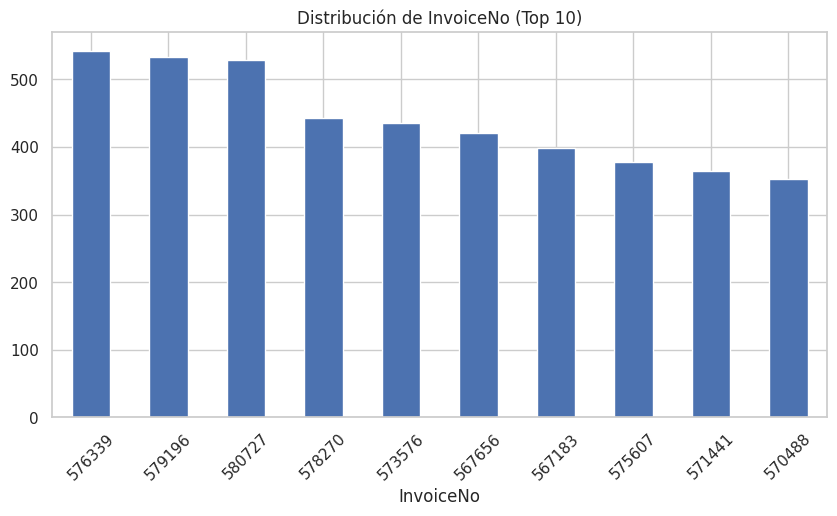


Análisis para StockCode:


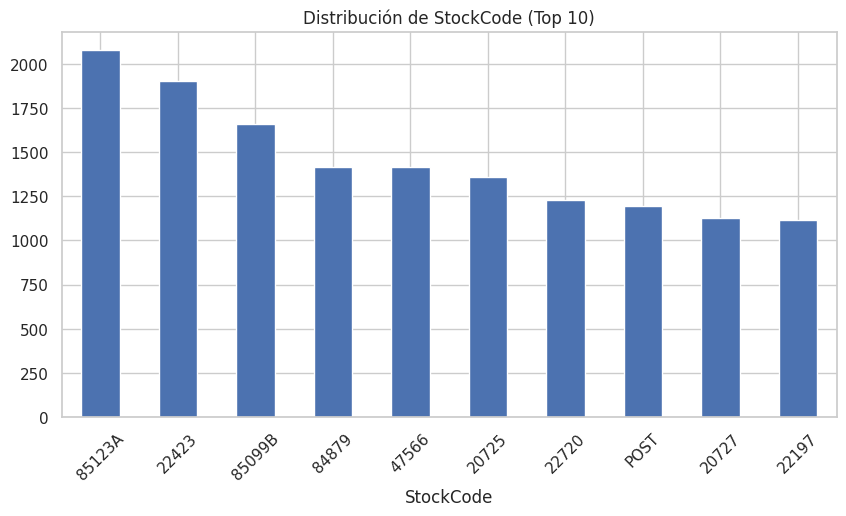


Análisis para clean_descriptions:


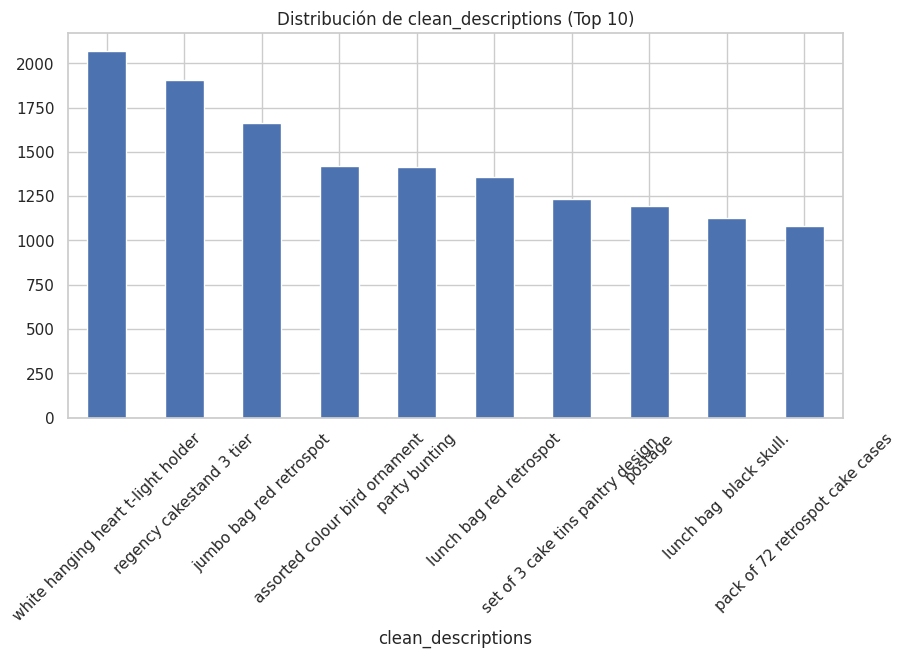


Análisis para Country:


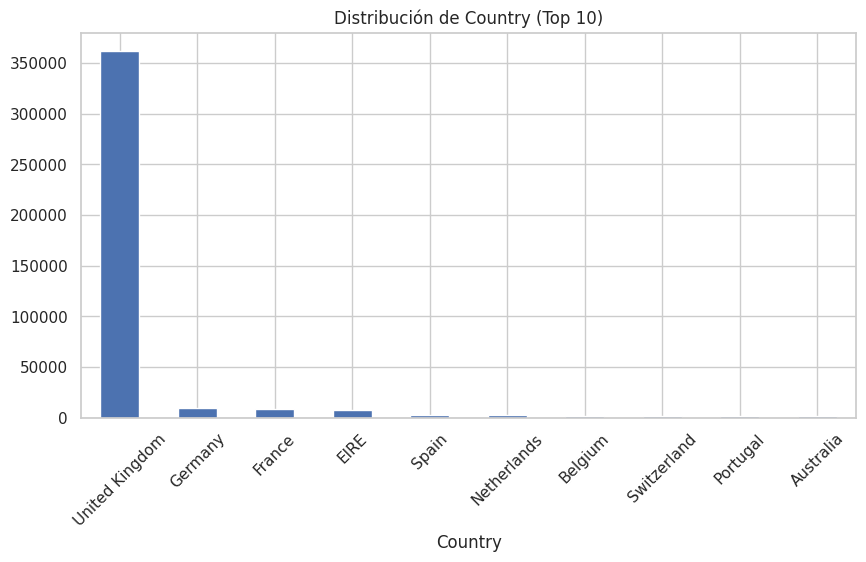


Análisis para CustomerID:


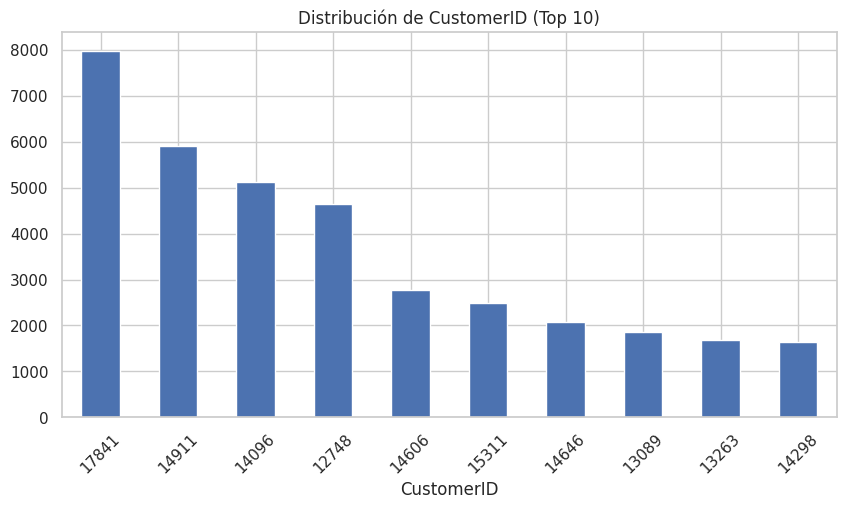

In [108]:
# Análisis de clientes principales
top_customers = customer_metrics.sort_values('TotalSpent', ascending=False).head(10)

# Mover el bloque de código dentro de la función analyze_categorical
def analyze_categorical(df, columns):
    for col in columns:
        print(f"\nAnálisis para {col}:")

        # Gráfico de barras para las principales categorías  <--- Moved here
        plt.figure(figsize=(10, 5))
        df[col].value_counts().head(10).plot(kind='bar')
        plt.title(f'Distribución de {col} (Top 10)')
        plt.xticks(rotation=45)
        plt.show()

analyze_categorical(df, categoricas_nominales)

# Conclusiones y Hallazgos Clave

1. Concentración de Ventas por Factura (InvoiceNo)

Top 10 facturas representan solo ~1.2% del total (ej: factura 576339 con 542 ítems, 0.13%).

Número único de facturas: 22,190 (alta variabilidad).

Hallazgo:
* Pocas facturas concentran gran volumen de ítems (posibles compras corporativas o eventos).
* Oportunidad para analizar patrones en facturas recurrentes (ej: cliente 17841 con 7,983 ítems en solo 169 facturas).


---


2. Productos Más Vendidos (StockCode y clean_descriptions)

Productos estrella:

"White hanging heart t-light holder" (85123A): 2,077 unidades (0.51%).

"Regency cakestand 3 tier" (22423): 1,905 unidades (0.47%).

Número único de productos: 3,684 (alta diversidad).

Hallazgo:
* Larga cola de productos: El 80% de los productos probablemente contribuye menos del 20% de ingresos (principio de Pareto inverso).
* Estrategia: Optimizar inventario enfocándose en los top 100 productos (ej: decoración y regalos).

---

3. Distribución Geográfica (Country)

Reino Unido domina: 88.95% de las transacciones.

Otros mercados: Alemania (2.33%), Francia (2.09%), EIRE (1.84%).

Hallazgo:
* Oportunidad internacional: Países como Alemania y Francia tienen menor penetración pero mayor ticket promedio (validar con datos de gasto).
* Riesgo: Alta dependencia del mercado británico (diversificar campañas).

---

4. Comportamiento de Clientes (CustomerID)

Top cliente (17841): 7,983 ítems (1.96% del total), pero solo 169 facturas (≈47 ítems/factura).

Segundo cliente (14911): 5,903 ítems, pero 248 facturas (≈24 ítems/factura) y mayor gasto total (£132,573).

Número único de clientes: 4,372.

Hallazgo:
* Segmentos claros:
* Compradores "bulk" (como 17841): Muchos ítems de bajo valor.
* Compradores frecuentes (como 14911): Menos ítems pero más caros.

---

Recomendaciones Estratégicas

Enfoque en clientes VIP:
* Crear programas de fidelización para los top 20% de clientes (ej: 14911).
* Ofrecer descuentos por volumen a compradores "bulk" (ej: 17841).

Optimización de inventario:

* Priorizar stock de productos top 10 y eliminar slow-movers (ej: productos con <10 ventas).

Expansión internacional:
* Campañas localizadas para Alemania/Francia con productos similares a los más vendidos en UK.

Análisis de facturas recurrentes:
* Investigar por qué ciertas facturas (ej: 576339) tienen +500 ítems (posibles negocios B2B).